# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp 
from skimage.measure import perimeter
import matplotlib.patches as patches

def Moore_neighbourhood(grid,i,j):
    """ This funtion returns a tuple Moore neighbourhood of lattice site (i,j) 
        on the grid. If grid[i,j,0] then the cell id is given.
        if grid[i,j,1] then the cell type is given.

        Args:
            grid(ndarray):  The grid of the simulation
            i(int):         The row index of the grid
            j(int):         The column index of the grid

        Returns:
            tuple:          The Moore neighbourhood
    """
    return (grid[i - 1, j - 1, :], grid[i - 1, j, :], grid[i - 1, j + 1, :], 
            grid[i + 1, j - 1, :], grid[i + 1, j, :], grid[i + 1, j + 1, :],
            grid[i, j - 1, :], grid[i, j + 1, :])

def Von_Neumann_neighbourhood(grid,i,j,k):
    """ This funtion returns a dictionary of the Von Neumann neighbourhood
        of lattice site (i,j) on the grid for a cell type or cell id 
        depending on input k. Here the keys are the indices and 
        the values the grid elements.
        If k == 0 then the cell id is given.
        If k == 1 then the cell type is given.

        Args:
            grid(ndarray):  The grid of the simulation
            i(int):         The row index of the grid
            j(int):         The column index of the grid
            k(int):         The depth index of the grid (0 = cell id or 1 = cell type)

        Returns:
            dict:          The Moore neighbourhood
    """
    return {(i - 1, j): grid[i - 1, j, k], (i + 1, j): grid[i + 1, j, k],
            (i, j - 1): grid[i, j - 1, k], (i, j + 1): grid[i, j + 1, k]}

def Kronecker_delta(σ1,σ2):
    """ This funtion returns the Kronecker delta of two variables.
        If the variables are equal it returns 1 else 0.
        Args:
            σ1(int):  First variable. (In this case the cell type)
            σ2(int):  Second variable. (In this case the cell type)

        Returns:
            0 or 1 (int):  Kronecker delta value.
    """
    return int(σ1 == σ2)

def percolation_detector(array):
    """
    This function checks if a population group contains a cluster that percolates,
    either vertically, horizontally or both.

    Args:
        array:  Matrix of intergers where 0 is the empty space and the other 
                intergers a population agent.

    Returns:
        percolation_check:  The keys are the population value (population group) and
                            the values is an array of boolian values. The first 
                            vertical percolation and the second horizontal.
    """

    # Get the number of populations
    unique_values = np.unique(array)

    # Create a dictionary to store the percolation check for each population group
    percolation_check = {}

    # Loop through each population group and determines the cluster(s) and their sizes.
    for value in unique_values:
        
        # Check if agent type is not a fixed object
        if value >= 0:

            # Create a mask of the population group
            mask = array == value

            # Extract all the clusters of the population group
            labels, num_clusters = sp.ndimage.label(mask)
            clusters = sp.ndimage.sum(mask, labels, index=np.arange(labels.max() + 1))
            
            # Set the percolation checks to false
            percolates_vertically = False
            percolates_horizontally = False

            # Loop through each cluster of a single poplulation group and check if it percolates
            # If the cluster is not big enough to percolate or if a previous cluster already percolated the check is skipped.
            for label in range(1,num_clusters+1):

                # Check if the cluster is big enough to percolate vertically
                if percolates_vertically == False and clusters[label] >= mask.shape[0]:
                    if label in labels[:,0] and label in labels[:,-1]:
                        percolates_vertically = True
                    
                # Check if the cluster is big enough to percolate horizontally
                if percolates_horizontally == False  and clusters[label] >= mask.shape[1]:
                    if label in labels[0,:] and label in labels[-1,:]:
                        percolates_horizontally = True

            # Store the percolation check for the population group
            percolation_check[value] = [percolates_vertically, percolates_horizontally]

    return percolation_check

def cluster_finder(mask):
    """This function has as imput a binary matrix of one population group
       and returns the size of cluster(s).

    Args:
        mask (2D numpy array): Matrix of intergers where 0 is not part of a cluster
        and 1 is part of a cluster.

    Returns:
        cluster: an array of clusters sizes for a input population group (mask)
    """
    # Labels the clusters
    lw, _ = sp.ndimage.label(mask)

    # sums the agents that are part of a cluster
    clusters = sp.ndimage.sum(mask, lw, index=np.arange(lw.max() + 1))
    return clusters[1:]

def multiple_cluster_finder(grid):
    """This function determines per cell id the size, perimiter 
        and type from the grid.

    Args:
        grid (2D numpy array):     Matrix of intergers where 0 is the empty space
                                    and the other intergers are cell typees.

    Returns:
        Returns:
        sigma (2D ndarray):         Matrix of intergers where 0 is the empty space
                                    and the other intergers are cell id's.
        cluster_sizes (dictonary):  The keys are the cell id's and the values are 
                                    an array of cell size(s), perimiter(s) and cell types.
    """

    # Get the number of populations
    unique_values = np.unique(grid)

    # Create a dictionary to store the percolation check for each population group
    sigma = np.zeros(grid.shape)
    # Loop through each population group and determines the cluster(s) and their sizes.
    cluster_sizes = {}
    previous_num_cluster = 0
    for value in unique_values:
        
        # Check if agent type is not a fixed object
        if value > 0:

            # Create a mask of the cell type
            mask = grid == value

            # Extract all the clusters of the population group
            labels, num_clusters = sp.ndimage.label(mask)
            # relabel cells because sp.ndimage.label starts at 1 loop
            sigma[labels !=0] += previous_num_cluster
            previous_num_cluster += num_clusters
            sigma += labels

            # Loop through all cells to determine size, perimiter and type
            cell_ids = np.unique(sigma[mask])
            sizes = sp.ndimage.sum(mask, labels, index=np.arange(1,labels.max() + 1))
            for i in range(num_clusters):
                cluster_sizes[cell_ids[i]] = sizes[i], perimeter(sigma == cell_ids[i], 8), value
    return sigma, cluster_sizes

def H_vol(cluster_sizes, A_τ, Lambda_v):
    """This function calculates the volume hamiltonian of the system.
        The cell size for each cell on the grid is compared to the target cell size A_τ.
        The difference is squared and summed. The strength is determined by Lambda.

    Args:
        cluster_sizes (dictonary):  The keys are the cell id's and the values are 
                                    an array of cell size(s), perimiter(s) and cell types.
        A_τ (dictonary):            The keys are the cell types and the values are the 
                                    target areas (number of lattice sites that make up the cell).
        Lambda_v (int):             The strength of the volume constraint (Lagrange multiplier).

    Returns:
        Returns:
        h_vol (float):              The volume part of the hamiltonian.
    """
    return Lambda_v * sum([(cluster_sizes[σ][0] - A_τ[cluster_sizes[σ][2]])**2
                         for σ in cluster_sizes.keys()])

def H_peri(cluster_sizes, P_τ, Lambda_p):
    """This function calculates the perimeter hamiltonian of the system.
        The cell perimeter for each cell on the grid is compared to the target cell perimeter P_τ.
        The difference is squared and summed. The strength is determined by Lambda_p.

    Args:
        cluster_sizes (dictonary):  The keys are the cell id's and the values are 
                                    an array of cell size(s), perimiter(s) and cell types.
        P_τ (dictonary):            The keys are the cell types and the values are the 
                                    target perimeters (number of lattice sites that make up the perimeter).
        Lambda_p (int):             The strength of the perimeter constraint (Lagrange multiplier).

    Returns:
        Returns:
        h_peri (float):              The perimeter part of the hamiltonian.
    """
    return Lambda_p * sum([(cluster_sizes[σ][1] - P_τ[cluster_sizes[σ][2]])**2
                         for σ in cluster_sizes.keys()])

def H_bond(grid,i,j,J):
    """This function calculates the hamiltonian bond, 
        the interaction between cells and medium  of the system.
        The cell perimeter for each cell on the grid is compared to the target cell perimeter P_τ.
        The difference is squared and summed. The strength is determined by Lambda_p.

    Args:
        Args:
            grid (3D ndarray):  The grid of the simulation.
            i (int):            The row index of the grid.
            j (int):            The column index of the grid.
            J (dictonary):      The keys are the cell types interactions between: 
                                    same cells
                                    different cells
                                    cell and medium
                                The values are the interaction strengths.

    Returns:
        Returns:
        h_bond (float):         The bond part of the hamiltonian.
    """
    # determine the Moore neighbourhood
    neigbours = Moore_neighbourhood(grid,i,j)
    return sum([J[(neigbour[1], grid[i, j, 1])] * 
                (1 - Kronecker_delta(neigbour[0], grid[i, j, 0])) 
                for neigbour in neigbours])

def trial_move(grid, i,j, cluster_sizes):
    """This function does a trial move where first a neighbour from the 
        Von Neumann neighbourhood is selected. Then the trial grid is updated.
        Next the cell id's, cell size(s), perimeter(s) and cell type updated.

    Args:
        Args:
            grid (3D ndarray):          The grid of the simulation.
            i (int):                    The row index of the grid.
            j (int):                    The column index of the grid.
            cluster_sizes (dictonary):  The pre-updated cell information:
                                            The keys are the cell id's and the values  
                                            are an array of cell size(s), perimiter(s) 
                                            and cell types.

    Returns:
        Returns:
        trial_grid (3D ndarray):        The trial move updatead grid.
        trial_cluster_sizes (dictonary):The trial move updated cell information:
                                            The keys are the cell id's and the values  
                                            are an array of cell size(s), perimiter(s) 
                                            and cell types.
        same_check (Boolean):           1 if cell types are different and 0 otherwise.

        If the neighbour is not the same cell type.
        cluster_sizes (dictonary):      The pre-updated cell information:
                                            The keys are the cell id's and the values  
                                            are an array of cell size(s), perimiter(s) 
                                            and cell types.
                                    
    """
    # Randomly choose a neighbour from the Von Neumann neighbourhood
    trial_grid = grid.copy()
    new_i, new_j = choose_neighbour(grid, i,j)

    # Update trial grid if choocen neighbour is not the same cell type
    same_check = grid[i, j, 1] != grid[new_i, new_j, 1]
    if same_check:
        trial_grid[i, j, 0] = trial_grid[new_i, new_j, 0]
        trial_grid[i, j, 1] = trial_grid[new_i, new_j, 1]

        # Update cell id's, cell size(s), perimeter(s) and cell type.
        sigma, trial_cluster_sizes = multiple_cluster_finder(trial_grid[1:-1, 1:-1, 1])
        trial_grid[1:-1, 1:-1, 0] = sigma
        return trial_grid, trial_cluster_sizes, same_check
    else:
        return grid, cluster_sizes, same_check

def choose_neighbour(grid, i,j):
    """This function selects a neighbour from the Von Neumann neighbourhood. 

    Args:
        Args:
            grid (3D ndarray):          The grid of the simulation.
            i (int):                    The row index of the grid.
            j (int):                    The column index of the grid.

    Returns:
        Returns:
        new_i (int):                    The new row index of the grid.
        new_j (int):                    The new column index of the grid.
    """
    # Get the neighbourhood base on the cell type
    neighbourhood = Von_Neumann_neighbourhood(grid,i,j,1)
    # Create a list of all the neighbours (houses haha)
    house_key = list(neighbourhood.keys())
    # Randomly choose a neighbour
    choice = np.random.randint(len(house_key))
    # Get the new indices
    new_i, new_j = house_key[choice]
    return new_i, new_j


def CPM(grid_0, cluster_sizes, experiment = 0, debug = False):
    # Create grid
    grid = grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    Volumes = []
    Perimeters = []

    H_vols = []
    H_peris = []
    H_bonds = []

    H_vols_trials = []
    H_peris_trials = []
    H_bonds_trials = []

    delta_H = []
    delta_H_vols = []
    delta_H_bonds = []
    delta_H_peris = []

    Ps = []
    
    for step in range(n_steps):
        # print((step/(n_steps-1))*100, end="\r")
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid[:,:,1]))
        i, j = np.random.randint(1,nx+1, 2)

        trial_grid, trial_cluster_sizes, same_check = trial_move(grid, i,j, cluster_sizes)
        # Check witch Hamiltonian is needed for witch experiment
        if same_check:
            if experiment == 0:
                h_vol = H_vol(cluster_sizes, A_τ, Lambda_v)
                h_bond = H_bond(grid, i, j, J)
                h_peri = H_peri(cluster_sizes, P_τ, Lambda_p)

                h_vol_trials = H_vol(trial_cluster_sizes, A_τ, Lambda_v)
                h_bond_trials = H_bond(trial_grid, i, j, J)
                h_peri_trials = H_peri(trial_cluster_sizes, P_τ, Lambda_p)

            elif experiment == 1:
                h_vol = H_vol(grid, cluster_sizes, A_τ, Lambda_v)
                h_bond = 0
                h_peri = 0

                h_vol_trials = H_vol(grid, trial_cluster_sizes, A_τ, Lambda_v)
                h_bond_trials = 0
                h_peri_trials = 0

            elif experiment == 2:
                h_vol = H_vol(grid, cluster_sizes, A_τ, Lambda_v)
                h_bond = 0
                h_peri = H_peri(cluster_sizes, P_τ, Lambda_p)

                h_vol_trials = H_vol(grid, trial_cluster_sizes, A_τ, Lambda_v)
                h_bond_trials = 0
                h_peri_trials = H_peri(trial_cluster_sizes, P_τ, Lambda_p)

            elif experiment == 4:
                h_vol = 0
                h_bond = H_bond(grid, i, j, J)
                h_peri = 0

                h_vol_trials = 0
                h_bond_trials = H_bond(trial_grid, i, j, J)
                h_peri_trials = 0
                
            # Hamiltonian
            H = h_vol + h_bond + h_peri
            H_trial = h_vol_trials + h_bond_trials + h_peri_trials

            H_vols.append(h_vol)
            H_bonds.append(h_bond)
            H_peris.append(h_peri)

            H_vols_trials.append(h_vol_trials)
            H_bonds_trials.append(h_bond_trials)
            H_peris_trials.append(h_peri_trials)

            delta_H.append(H_trial - H)
            delta_H_vols.append(h_vol_trials - h_vol)
            delta_H_bonds.append(h_bond_trials - h_bond)
            delta_H_peris.append(h_peri_trials - h_peri)

            
            # Probability
            P = np.exp(- (H_trial - H) / (k_B * T))
            Ps.append(P)

            # Update grid
            if P > np.random.sample():
                grid = trial_grid
                cluster_sizes = trial_cluster_sizes
        Volumes.append(cluster_sizes[1][0])
        Perimeters.append(cluster_sizes[1][1])

    # # Create figures        
    # fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    # ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    # ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    # ax.grid(visible =True, which='major', c='k', alpha=0.2)
    # ax.set_xlabel('n')
    # ax.set_ylabel(r'$\left < \left| M \right| \right >$')
    # # ax.set_title('Magnetization modulus for J = %d' % J)
    
    # ax = plt.subplot2grid((1, 3), (0, 2))
    # cmap = plt.get_cmap('hot_r', n_id + 1)
    # fig.colorbar(ax.matshow(grid[1:-1, 1:-1, 1], cmap = cmap, vmin=0 - 0.5, 
    #                   vmax=(n_id + 1) -.5), ticks= np.arange(0, (n_id + 1)))
    # ax.set_title('n = %i' % n_steps)
    # ax.axis('off')
    
    # plt.tight_layout()
    # plt.show()   
    if debug == True:
        plot_hamiltonians(delta_H, Ps, H_vols, H_vols_trials, delta_H_vols, H_bonds, 
             H_bonds_trials, delta_H_bonds, H_peris, H_peris_trials, delta_H_peris)
        
    if experiment == 0:
        return grid, cluster_sizes
    elif experiment == 1:
        return grid, cluster_sizes, Volumes
    elif experiment == 2:
        return grid, cluster_sizes, Perimeters
    elif experiment == 4:
        return grid, cluster_sizes
        
    
def Begin_End_plot(grid_0, grid, n_id):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap('jet', (n_id + 1))
    im = ax.imshow(grid_0[:,:,1],cmap = cmap, aspect="auto", vmin=0 - 0.5, 
                        vmax=(n_id + 1) -.5)
    # # Loop over data dimensions and create text annotations.
    # for i in range(1,nx+1):
    #     for j in range(1,nx+1):
    #         text = ax.text(j, i, grid_0[i,j,0],
    #                        ha="center", va="center", color="black", fontsize = 4)
    fig.colorbar(im, ticks= np.arange(0, (n_id + 1)))
    plt.show()   

    fig, ax = plt.subplots()
    cmap = plt.get_cmap('jet', (n_id + 1))
    im = ax.imshow(grid[:,:,1],cmap = cmap, aspect="auto", vmin=0 - 0.5, 
                        vmax=(n_id + 1) -.5)
    # # Loop over data dimensions and create text annotations.
    # for i in range(1,nx+1):
    #     for j in range(1,nx+1):
    #         text = ax.text(j, i, grid_0[i,j,0],
    #                        ha="center", va="center", color="black", fontsize = 4)
    fig.colorbar(im, ticks= np.arange(0, (n_id + 1)))
    plt.show() 
    return

def plot_hamiltonians(delta_H, Ps, H_vols, H_vols_trials, delta_H_vols, H_bonds, 
             H_bonds_trials, delta_H_bonds, H_peris, H_peris_trials, delta_H_peris):
    plt.plot(delta_H)
    plt.xlabel("step")
    plt.ylabel(r"$\Delta H$")
    plt.show()

    plt.semilogy(Ps)
    plt.xlabel("step")
    plt.ylabel(r"$P$")
    plt.show()

    fig, axs = plt.subplots(3)
    axs[0].plot(H_vols)
    axs[0].set_xlabel("step")
    axs[0].set_ylabel(r"$H_{vol}$")

    axs[1].plot(H_vols_trials)
    axs[1].set_xlabel("step")
    axs[1].set_ylabel(r"trial $H_{vol}$")

    axs[2].plot(delta_H_vols)
    axs[2].set_xlabel("step")
    axs[2].set_ylabel(r"$\Delta H_{vol}$")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(3)
    axs[0].plot(H_bonds)
    axs[0].set_xlabel("step")
    axs[0].set_ylabel(r"$H_{bond}$")

    axs[1].plot(H_bonds_trials)
    axs[1].set_xlabel("step")
    axs[1].set_ylabel(r"trial $H_{bond}$")

    axs[2].plot(delta_H_bonds)
    axs[2].set_xlabel("step")
    axs[2].set_ylabel(r"$\Delta H_{bond}$")
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(3)
    axs[0].plot(H_peris)
    axs[0].set_xlabel("step")
    axs[0].set_ylabel(r"$H_{peri}$")

    axs[1].plot(H_peris_trials)
    axs[1].set_xlabel("step")
    axs[1].set_ylabel(r"trial $H_{peri}$")

    axs[2].plot(delta_H_peris)
    axs[2].set_xlabel("step")
    axs[2].set_ylabel(r"$\Delta H_{peri}$")
    plt.tight_layout()
    plt.show()

    plt.plot(delta_H_vols, label = r"H_{vol}", alpha = 0.5)
    plt.plot(delta_H_bonds, label = r"H_{bond}", alpha = 0.5)
    plt.plot(delta_H_peris, label = r"H_{peri}", alpha = 0.5)
    plt.xlabel("step")
    plt.ylabel(r"$\Delta H$")
    plt.title(r"Influence energy difference per constraint")
    plt.grid()
    plt.legend()
    plt.show()

# Experiement 1

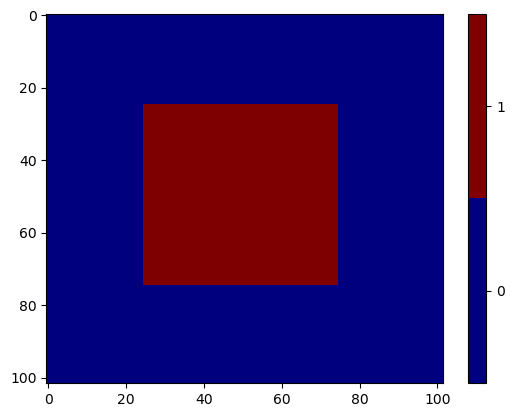

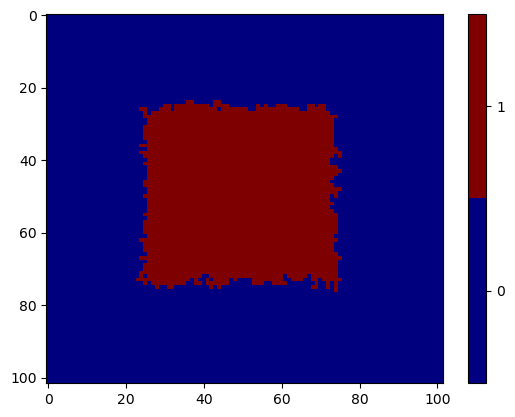

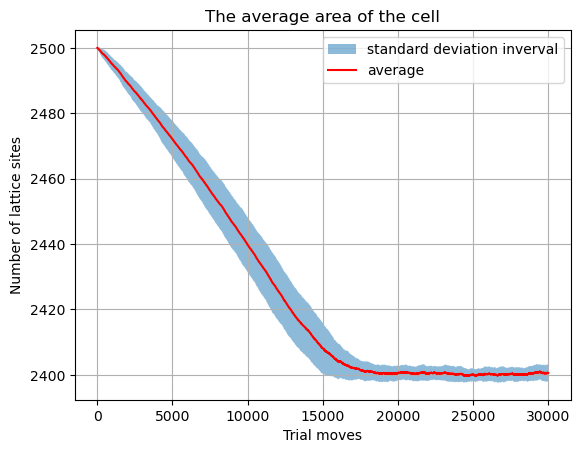

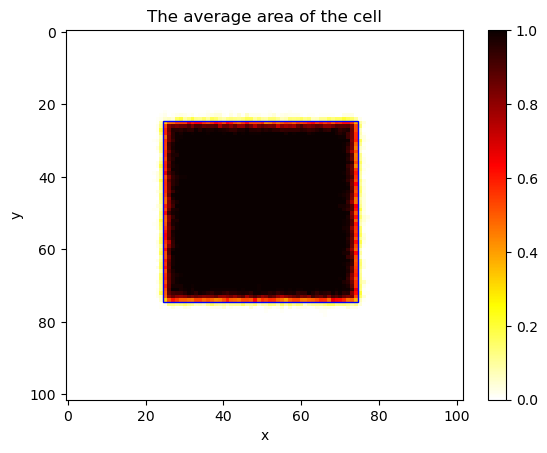

In [12]:
# Declare parameters
#---------------------------------------
n_steps = 30001
nx = 100
T = 10
k_B = 1

# Number of identities
n_id = 1

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):20, (1,0):20, (1,1): 4, 
     (0,2):8, (2,0):8, (1,2): 10, (2,1): 10, (2,2): 4}

# The target volume for each cell type  discuss it!!!
A_τ = {1: 2400, 2: 25}
P_τ = {1: 170, 2: 15}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 1
Lambda_p = 10

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)

# The second layer is the cell type (τ)
grid_0[25:75, 25:75, 1] = np.ones((50,50))

# The first layer is unique identity (σ)
sigma, cluster_sizes_0 = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma
mean_grid = np.zeros((nx + 2, nx + 2), dtype=int)

experiments_volums = []
for i in range(100):
    grid, cluster_sizes, Volumes = CPM(grid_0, cluster_sizes_0, 1)
    experiments_volums.append(Volumes)
    mean_grid += grid[:,:,1]
Begin_End_plot(grid_0, grid, n_id)
mean_grid = mean_grid / 100
experiments_volums = np.array(experiments_volums)
mean_volumes = np.mean(experiments_volums, axis=0)
std_volumes = np.std(experiments_volums, axis=0)

plt.fill_between(np.arange(len(mean_volumes)), mean_volumes - std_volumes, 
                 mean_volumes + std_volumes, alpha = 0.5, label = "standard deviation inverval")
plt.plot(np.arange(len(mean_volumes)), mean_volumes, color= "r", label = "average")
plt.xlabel(r"Trial moves")
plt.ylabel(r"Number of lattice sites")
plt.title(r"The average area of the cell")
plt.legend()
plt.grid()
plt.show()

fig, ax = plt.subplots()
cmap = plt.get_cmap('hot_r')
im = ax.imshow(mean_grid,cmap = cmap, aspect="auto", vmin=np.min(mean_grid), 
                    vmax=np.max(mean_grid))
square = patches.Rectangle((25-0.5, 25-0.5), 50, 50, edgecolor='blue', facecolor='none')
ax.add_patch(square)
fig.colorbar(im)
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title(r"The average area of the cell")
plt.show() 


# Experiment 2

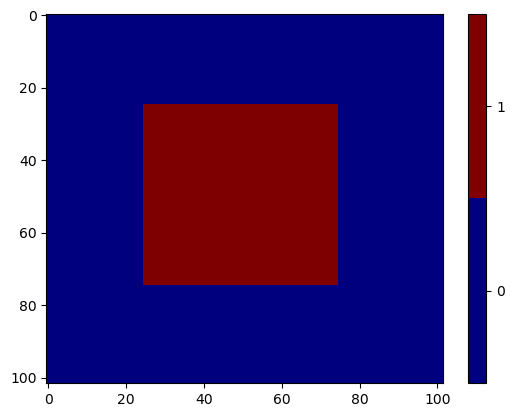

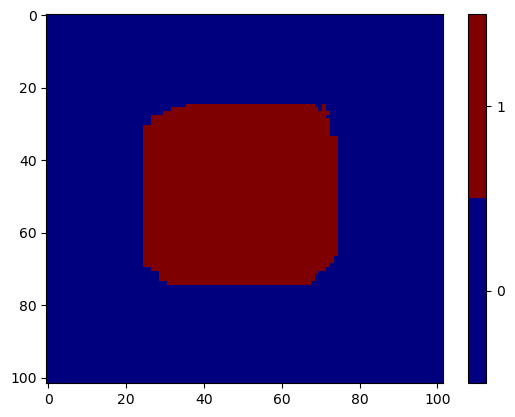

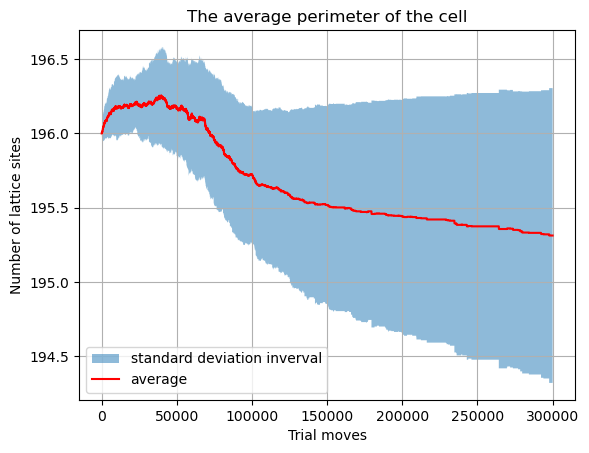

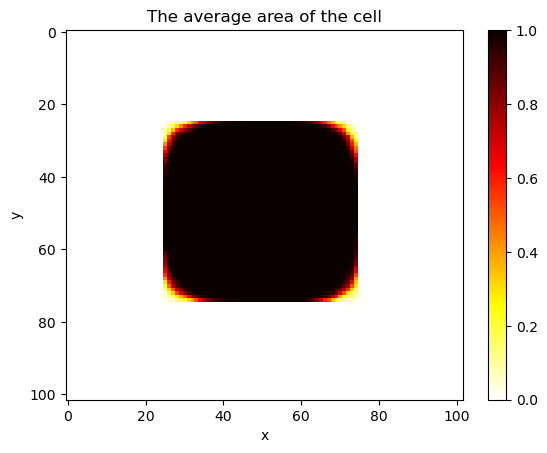

In [4]:
# Declare parameters
#---------------------------------------
n_steps = 300001
nx = 100
T = 10
k_B = 1

# Number of identities
n_id = 1

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):20, (1,0):20, (1,1): 4, 
     (0,2):8, (2,0):8, (1,2): 10, (2,1): 10, (2,2): 4}

# # The target volume for each cell type  discuss it!!!
# A_τ = {1: np.pi*(50**2)}
# P_τ = {1: 2 * np.pi * 50}

A_τ = {1: 2400}
P_τ = {1: 170}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 1
Lambda_p = 10

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)

# The second layer is the cell type (τ)
grid_0[25:75, 25:75, 1] = np.ones((50,50))

# The first layer is unique identity (σ)
sigma, cluster_sizes_0 = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma
mean_grid = np.zeros((nx + 2, nx + 2), dtype=int)

experiments_perimeters = []
for i in range(100):
    grid, cluster_sizes, Perimeters = CPM(grid_0, cluster_sizes_0, 2)
    experiments_perimeters.append(Perimeters)
    mean_grid += grid[:,:,1]
Begin_End_plot(grid_0, grid, n_id)
mean_grid = mean_grid / 100

experiments_perimeters = np.array(experiments_perimeters)
mean_perimeters = np.mean(experiments_perimeters, axis=0)
std_perimeters = np.std(experiments_perimeters, axis=0)

plt.fill_between(np.arange(len(mean_perimeters)), mean_perimeters - std_perimeters,
                  mean_perimeters + std_perimeters, alpha = 0.5, 
                  label = "standard deviation inverval")
plt.plot(np.arange(len(mean_perimeters)), mean_perimeters, color= "r", label = "average")
plt.xlabel(r"Trial moves")
plt.ylabel(r"Number of lattice sites")
plt.title(r"The average perimeter of the cell")
plt.legend(loc="lower left")
plt.grid()
plt.show()

fig, ax = plt.subplots()
cmap = plt.get_cmap('hot_r')
im = ax.imshow(mean_grid,cmap = cmap, aspect="auto", vmin=np.min(mean_grid), 
                    vmax=np.max(mean_grid))
square = patches.Rectangle((25-0.5, 25-0.5), 50, 50, edgecolor='blue', facecolor='none')
ax.add_patch(square)
fig.colorbar(im)
plt.xlabel(r"x")
plt.ylabel(r"y")
plt.title(r"The average area of the cell")
plt.show() 

# Experiment 3

C:\Users\jonat\AppData\Local\Temp\ipykernel_16748\307968256.py:403: RuntimeWarning: overflow encountered in exp
  P = np.exp(- (H_trial - H) / (k_B * T))


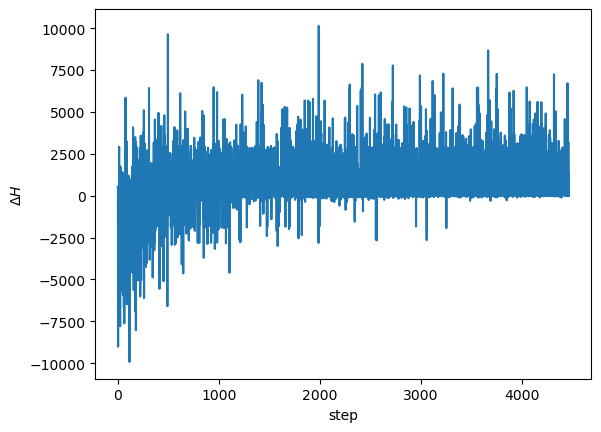

c:\Users\jonat\anaconda3\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


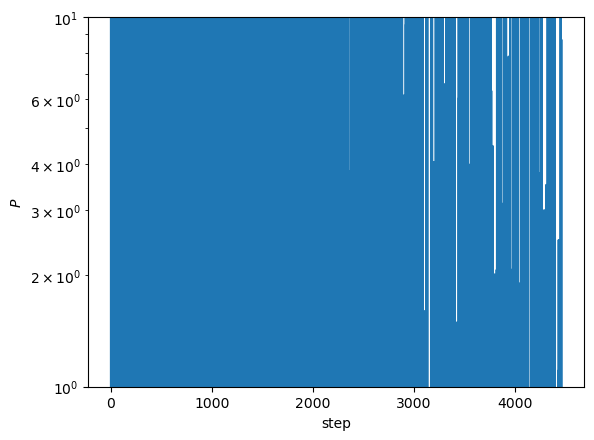

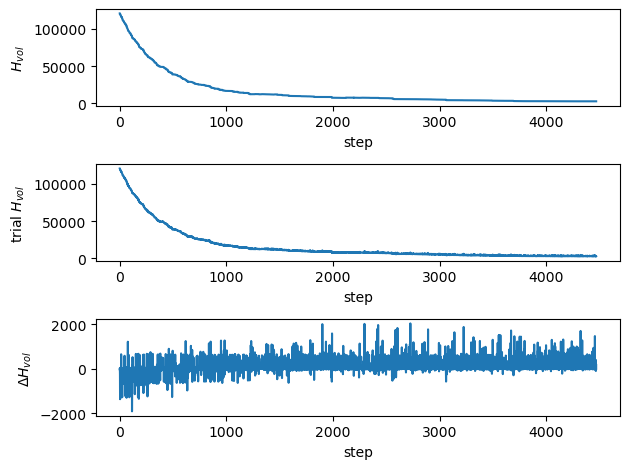

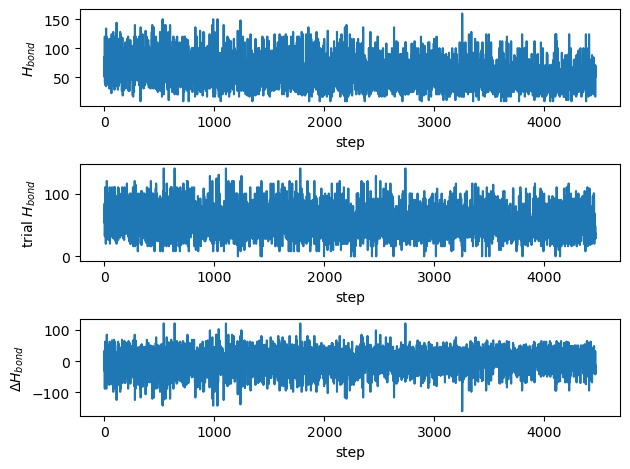

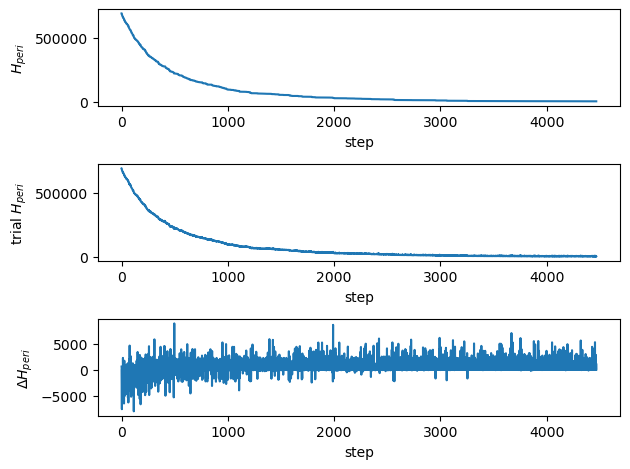

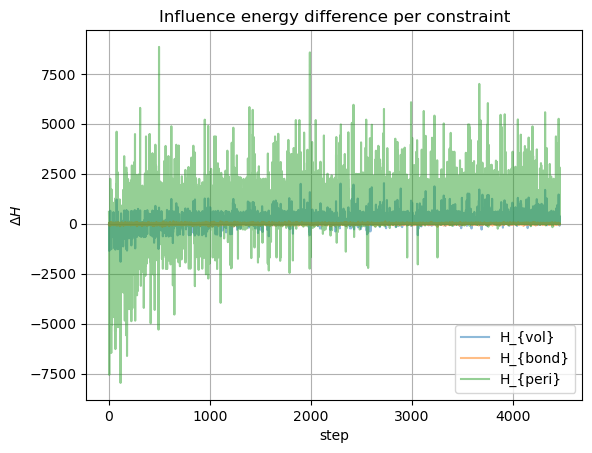

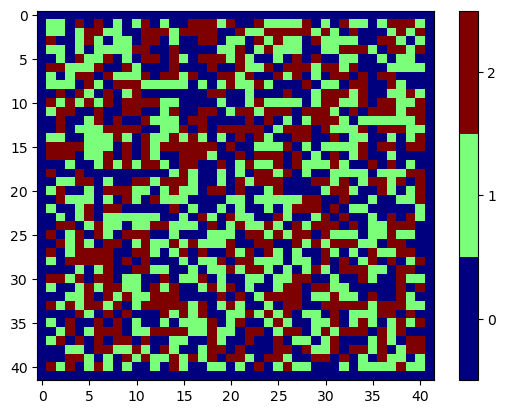

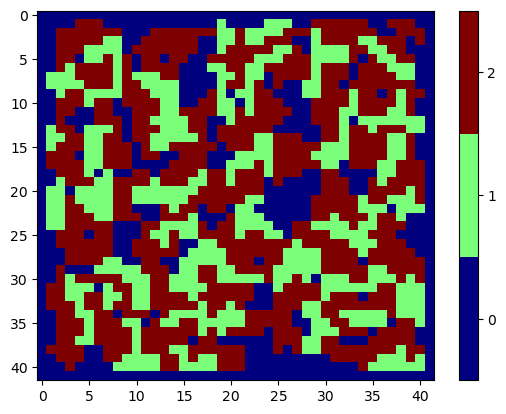

In [34]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 10
k_B = 1

# Number of identities
n_id = 2

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):20, (1,0):20, (1,1): 4, 
     (0,2):8, (2,0):8, (1,2): 10, (2,1): 10, (2,2): 4}

# The target volume for each cell type  discuss it!!!
A_τ = {1: 10, 2: 25}
P_τ = {1: 13, 2: 15}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 1
Lambda_p = 10

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)

# The second layer is the cell type (τ)
grid_0[1:-1, 1:-1, 1] = np.random.choice(np.arange(0, n_id + 1), (nx,nx))

# The first layer is unique identity (σ)
sigma, cluster_sizes = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma

grid, cluster_sizes = CPM(grid_0, cluster_sizes, debug=True)

Begin_End_plot(grid_0, grid, n_id)

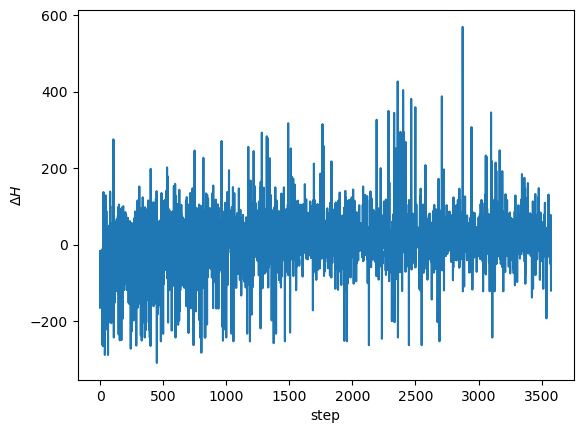

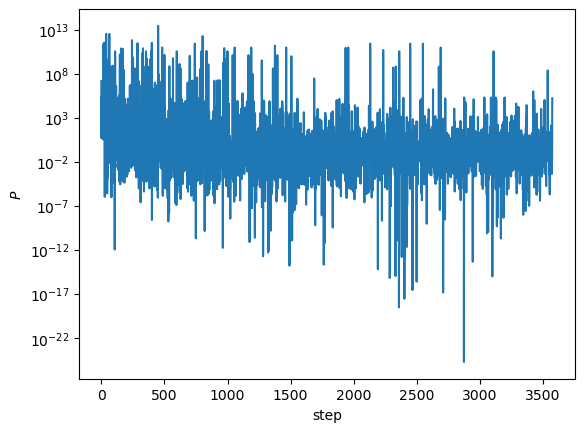

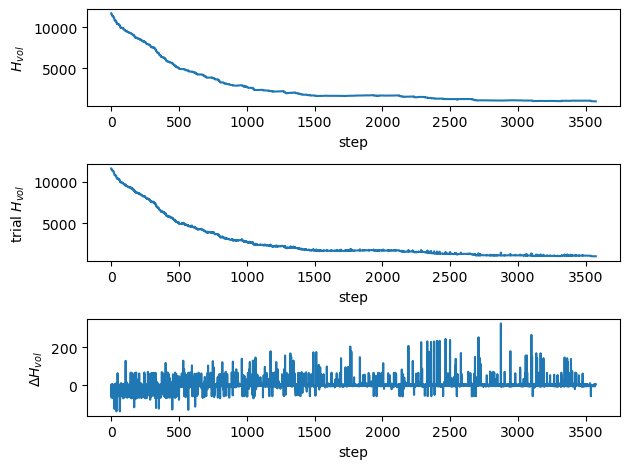

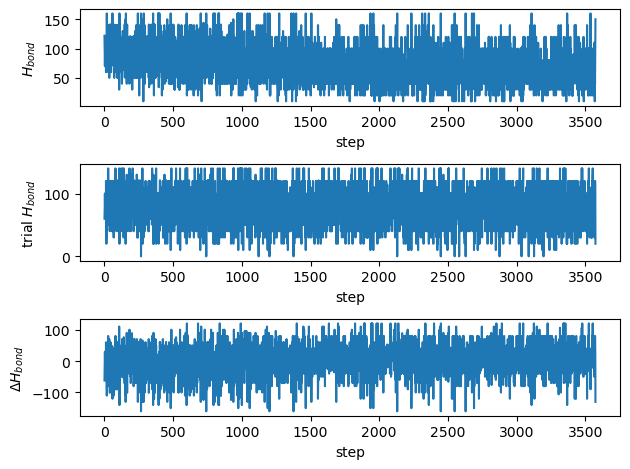

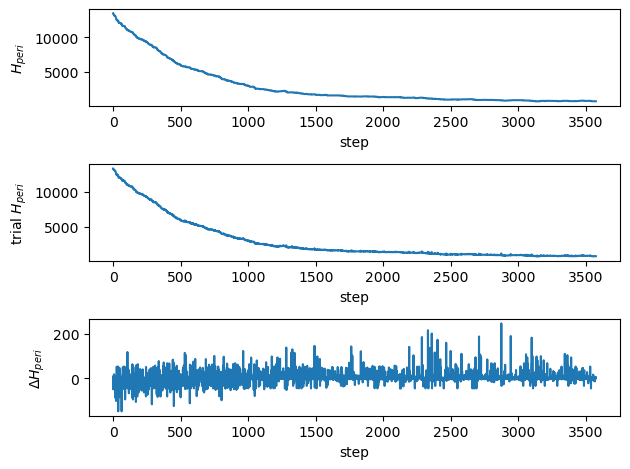

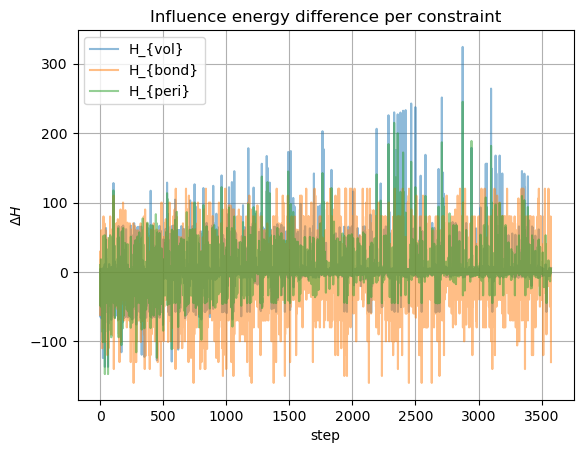

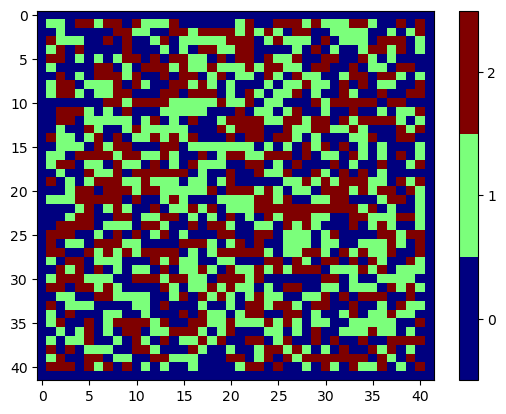

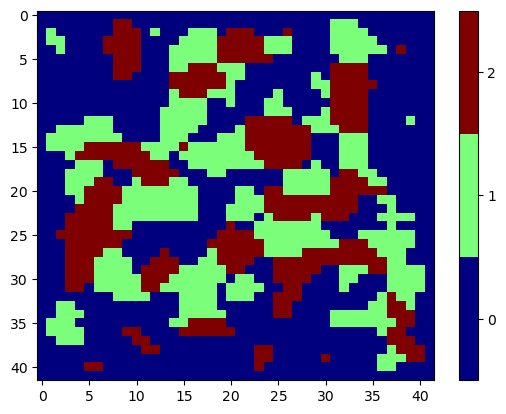

In [35]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 10
k_B = 1

# Number of identities
n_id = 2

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):10, (1,0):10, (1,1): 4, 
     (0,2):20, (2,0):20, (1,2): 20, (2,1): 20, (2,2): 1}

# The target volume for each cell type  discuss it!!!
A_τ = {1: 10, 2: 25}
P_τ = {1: 13, 2: 15}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 0.1
Lambda_p = 0.2

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)

# The second layer is the cell type (τ)
grid_0[1:-1, 1:-1, 1] = np.random.choice(np.arange(0, n_id + 1), (nx,nx))

# The first layer is unique identity (σ)
sigma, cluster_sizes = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma

grid, cluster_sizes = CPM(grid_0, cluster_sizes, experiment=0, debug=True)

Begin_End_plot(grid_0, grid, n_id)

# $J_{(m,A)} < J_{(A,A)}$

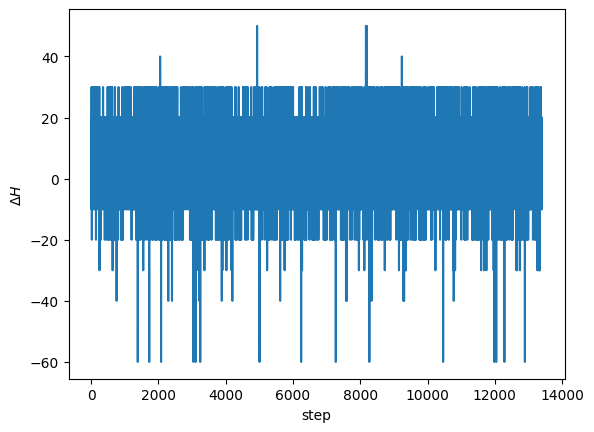

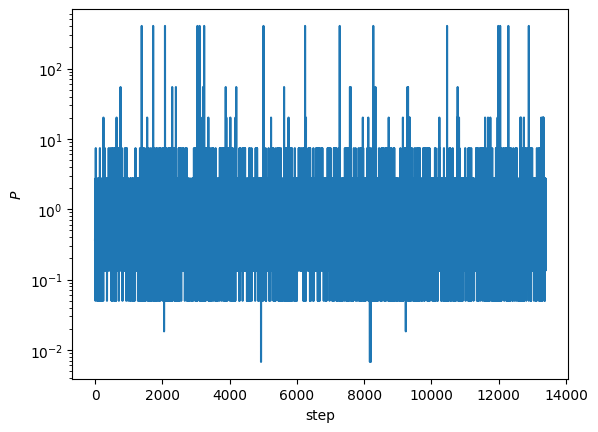

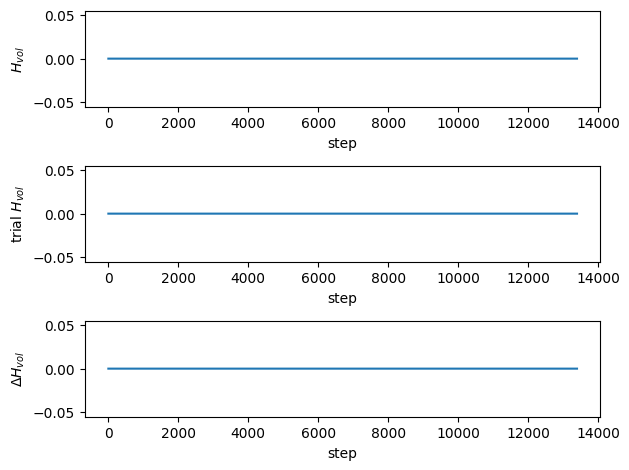

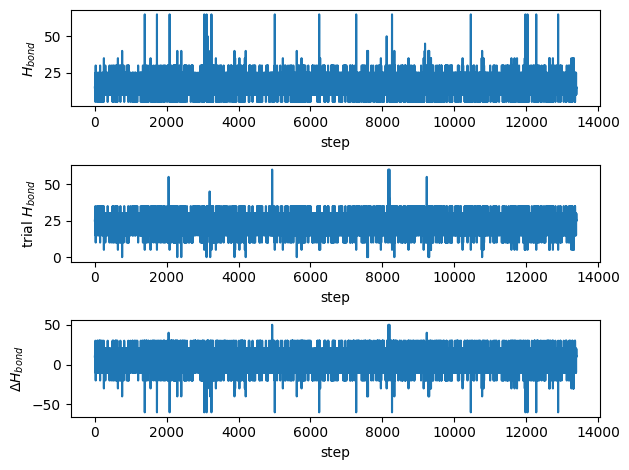

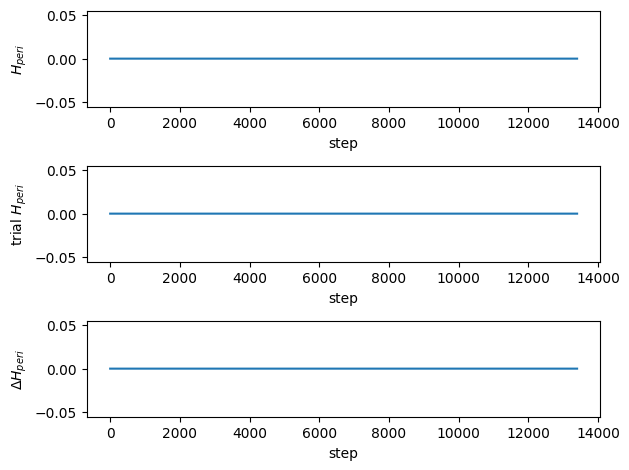

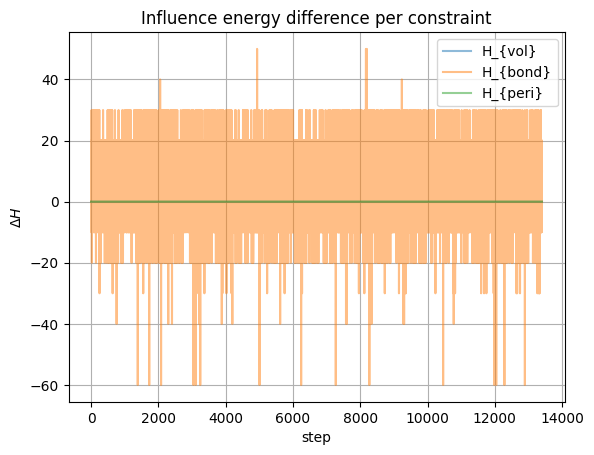

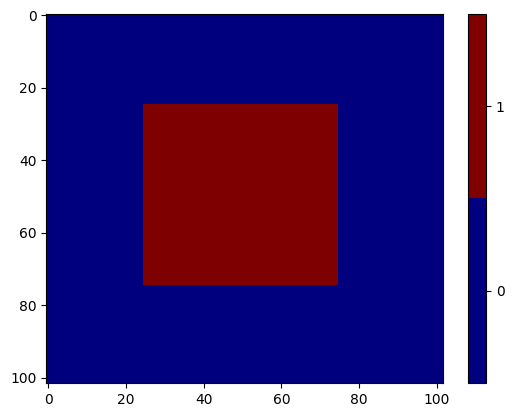

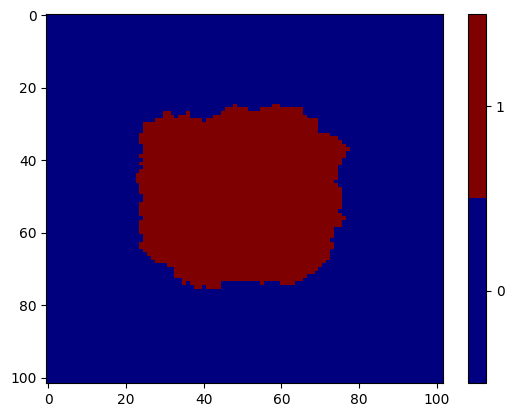

In [2]:
# Declare parameters
#---------------------------------------
n_steps = 1000001
nx = 100
T = 10
k_B = 1

# Number of identities
n_id = 1

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):5, (1,0):5, (1,1): 30}

# The target volume for each cell type  discuss it!!!
A_τ = {1: 500}
P_τ = {1: 1700}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 1
Lambda_p = 10

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)


# The second layer is the cell type (τ)
# grid_0[1:-1, 1:-1, 1] = np.random.choice(np.arange(0, n_id + 1), (nx,nx))
grid_0[25:75, 25:75, 1] = np.ones((50,50))

# The first layer is unique identity (σ)
sigma, cluster_sizes = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma

grid, cluster_sizes = CPM(grid_0, cluster_sizes, experiment=4, debug=True)

Begin_End_plot(grid_0, grid, n_id)

# $J_{(m,A)} > J_{(A,A)}$

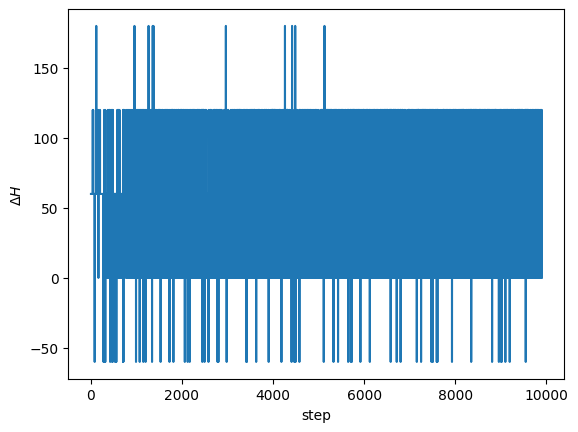

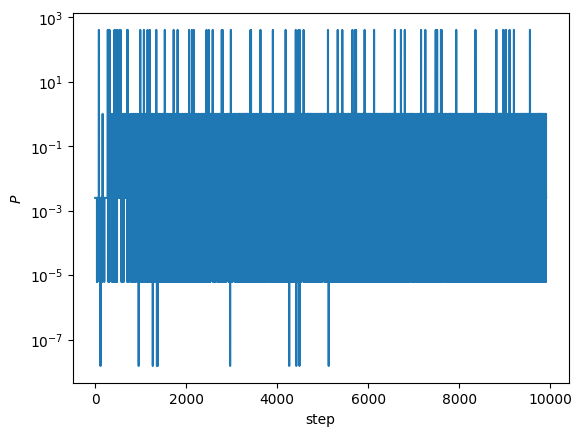

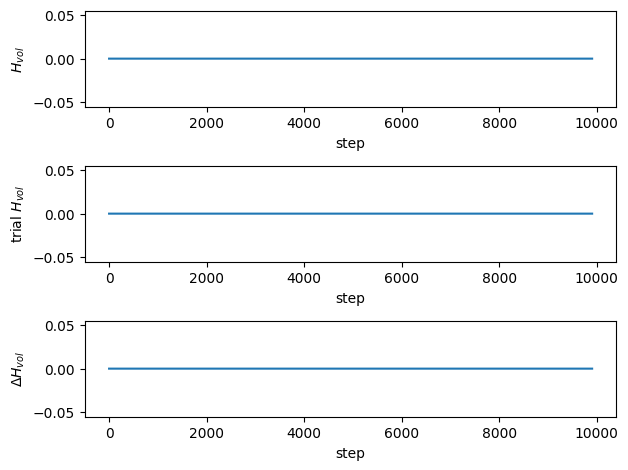

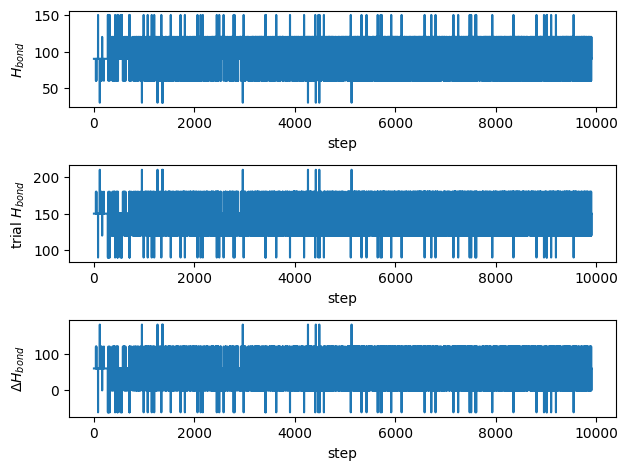

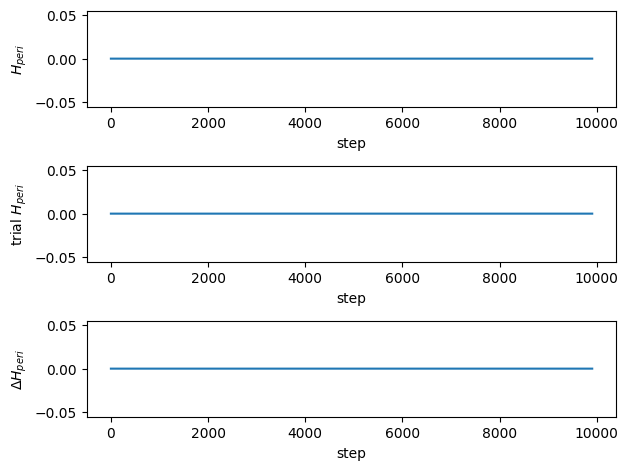

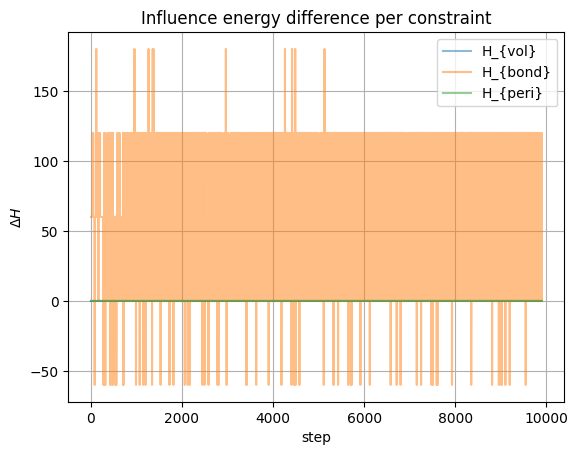

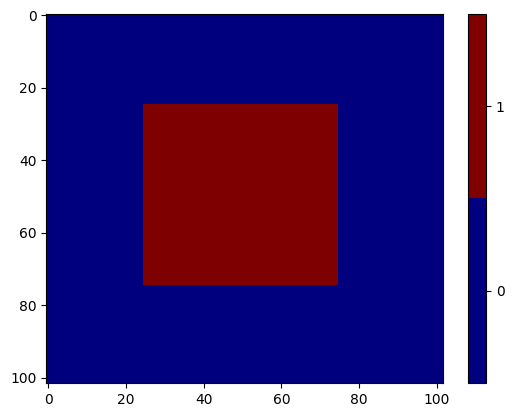

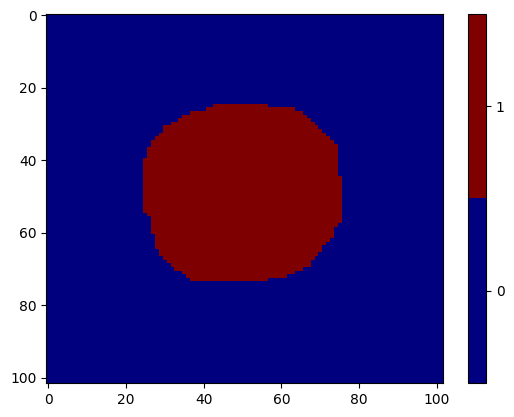

In [3]:
# Declare parameters
#---------------------------------------
n_steps = 1000001
nx = 100
T = 10
k_B = 1

# Number of identities
n_id = 1

# The interaction strength for each cell type combination
    # 0 = medium
    # 1 = cell type 1
    # 2 = cell type 2
    # J(cell 1, cell 2) = J(cell 2, cell 1) ALWAYS!
    # J(medium, cell) = J(cell, medium) ALWAYS!
J = {(0,0):0, (0,1):30, (1,0):30, (1,1): 5}

# The target volume for each cell type  discuss it!!!
A_τ = {1: 500}
P_τ = {1: 1700}

# The strength of the volume constraint (Lagrange multiplier)
Lambda_v = 1
Lambda_p = 10

# Create initial grid
grid_0 = np.zeros((nx + 2, nx + 2, 2), dtype=int)


# The second layer is the cell type (τ)
# grid_0[1:-1, 1:-1, 1] = np.random.choice(np.arange(0, n_id + 1), (nx,nx))
grid_0[25:75, 25:75, 1] = np.ones((50,50))

# The first layer is unique identity (σ)
sigma, cluster_sizes = multiple_cluster_finder(grid_0[1:-1, 1:-1, 1])
grid_0[1:-1, 1:-1, 0] = sigma

grid, cluster_sizes = CPM(grid_0, cluster_sizes, experiment=4, debug=True)

Begin_End_plot(grid_0, grid, n_id)

In [38]:
def find_cluster_sizes(grid):
    """This function finds all the cluster size(s) for all the populations on the 2D grid.

    Args:
        grid (2D numpy array): Matrix of intergers where 0 is the empty space
                                and the other intergers a population agent.

    Returns:
        cluster_sizes (dictonary): The keys are the population value (population group)
                                   and the values is an array of cluster size(s).
    """
    unique_values = np.unique(grid)
    cluster_sizes = {}

    for value in unique_values:
        # value 0 is an empty space thus not part of the cluster.
        if value != 0:
            # Isolate the selected population group form the rest (makt it a binary matrix)
            mask = grid == value
            # find the cluster size(s) for the selected population group.
            cluster_sizes[value] = cluster_finder(mask)
    return cluster_sizes

def cluster_analysis(cluster_sizes):
    """This function calculates the number of clusters, mean cluster size 
       with standard deviation.

    Args:
        cluster_sizes (dictonary): The keys are the population value (population group)
                                   and the values is an array of cluster size(s).

    Returns:
        cluster_data (dictonary): The keys are the population value (population group)
                                  and the values is an array of number of clusters,
                                  mean cluster size and standard deviation.
    """
    cluster_data = {}
    for value in cluster_sizes.keys():
        cluster_data[value] = [len(cluster_sizes[value]), np.mean(cluster_sizes[value]),
                                np.std(cluster_sizes[value])]
    return cluster_data


cluster_sizes_data = find_cluster_sizes(grid[:,:,1])
cluster_data = cluster_analysis(cluster_sizes_data)
print(cluster_data)

{1: [1, 2482.0, 0.0]}
